### Author: [Parvaneh Yaghoubi](https://github.com/parvanehyaghoubi)

# Muscle artefacts removal (component decomposition)

## Import libraries

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.interpolate as spi
from scipy import signal
from sklearn.decomposition import PCA,FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from pyts.decomposition import SingularSpectrumAnalysis

from PyEMD import EEMD

## Import Dataset

In [3]:
data = pd.read_excel("dataset/dataset.xlsx")
display(data.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3


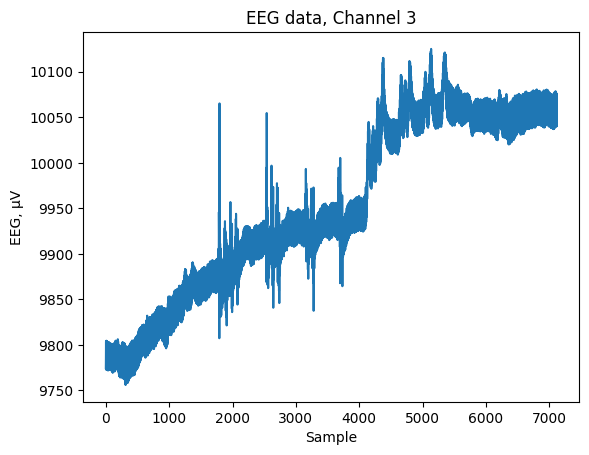

In [4]:
# select the data from the third channel
channel = 2
channel_data = data.iloc[:, channel]
channel_data = round(1000000*4.5*(channel_data/16777215),2)  # Convert data from ADC to µV

# plot the EEG data
plt.plot(channel_data)
plt.title("EEG data, Channel " + str(channel+1))
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

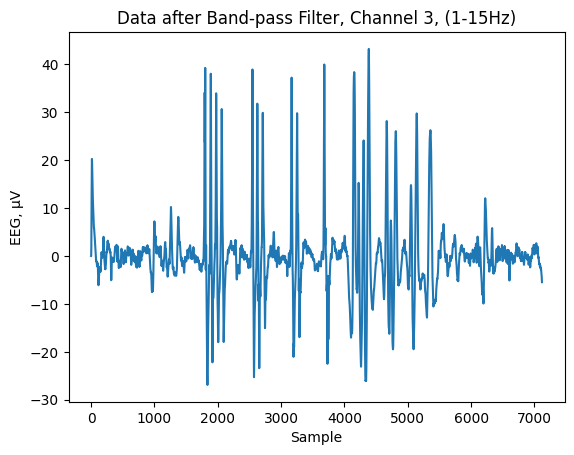

In [5]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 15  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Data after Band-pass Filter, Channel " +  str(channel+1) +", ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

In [6]:
# apply the band-pass filter for the whole dataset
data_bp_filtered = data.copy()  # copy the data

for ch in range(data_bp_filtered.shape[1]):
    data_bp_filtered.iloc[:, ch] = butter_highpass_filter(
        data=data_bp_filtered.iloc[:, ch],
        cutoff=cutoff_high,
        nyq=nyq,
        order=5)
    data_bp_filtered.iloc[:, ch] = butter_lowpass_filter(
        data=data_bp_filtered.iloc[:, ch],
        cutoff=cutoff_low,
        nyq=nyq,
        order=4)

## Remove muscle artifacts (component decomposition)

Removing muscle artifacts from EEG (Electroencephalography) data is a crucial preprocessing step to obtain clean and reliable brain signals. Muscle artifacts in EEG are caused by electrical activity from muscle contractions and can contaminate the brainwave recordings, making it challenging to analyze brain activity accurately.

Component decomposition techniques are advantageous for EEG analysis because they can effectively separate mixed signals into their underlying sources. This helps in isolating genuine neural activity from various artifacts, leading to cleaner and more interpretable EEG data. Such methods enhance the accuracy of brain signal analysis, improve the sensitivity to subtle neural patterns, and contribute to the reliability of EEG findings, making them essential tools in neuroscience research.

## Independent Component Analysis (ICA)

Independent Component Analysis (ICA) is a widely used signal processing technique for separating mixed sources in EEG data. It is particularly useful for decomposing EEG signals into their underlying independent components, which can represent different brain sources or artifacts. ICA helps to remove artifacts and identify specific brain-related activity, making it an essential tool for EEG data analysis.

**Positive**

*   Statistical Independence: ICA is designed to decompose mixed signals into components that are statistically independent. Muscle artifacts, which often have distinct temporal patterns and different frequency characteristics from neural signals, can be modeled as separate independent components.

* Multichannel Data: EEG signals are recorded from multiple channels, capturing spatially distributed neural and artifact sources. ICA's ability to simultaneously analyze multichannel data helps in separating out spatially localized muscle artifacts.

* Unmixing Overlapping Sources: EEG signals are a mixture of various sources, including neural activity, noise, and artifacts. ICA can unmix these overlapping sources by identifying their unique statistical properties, effectively isolating the muscle artifacts.

* Adaptive Filtering: ICA adaptively identifies artifact sources without relying on predefined templates or assumptions about their characteristics. This makes it versatile and effective in capturing a wide range of muscle artifact patterns.

* Reduced Dependence on Reference Electrodes: Unlike methods that rely on reference electrodes, ICA does not require specific electrode placements or reference strategies. This makes it useful for removing muscle artifacts even in scenarios where reference electrode placement might be suboptimal.

* Non-stationary Artifacts: Muscle artifacts can exhibit non-stationary characteristics, such as changes in amplitude or frequency. ICA's flexibility in capturing time-varying source patterns makes it suitable for removing such non-stationary artifacts.

* Enhanced Data Quality: By separating muscle artifacts from neural signals, ICA improves the overall quality of the EEG data, making subsequent analyses more accurate and reliable.

**Negative**

*   Assumption Violations: ICA assumes statistical independence of sources, which might not hold true for all types of artifacts. Muscle artifacts, in particular, can sometimes exhibit temporal or spectral correlations that violate this assumption.

* Modeling Complex Artifacts: Muscle artifacts can have complex and variable patterns that might not be well captured by the linear assumptions of ICA. This can lead to incomplete removal or misidentification of artifact components.

* Source Mixing: EEG signals often arise from a mixture of neural, noise, and artifact sources. ICA can sometimes mix artifact components with neural sources, leading to challenges in isolating and removing artifacts without affecting neural signals.

* Lack of Gold Standard: There is no "gold standard" for verifying the accuracy of ICA-based artifact removal. Validation typically involves visual inspection and expert judgment, which can introduce subjectivity.

* Over- or Under-Removal: ICA might over-remove or under-remove artifact components depending on how well the assumptions match the actual data. Over-removal can distort the underlying neural activity, while under-removal leaves artifacts in the data.

* Varying Muscle Patterns: Muscle artifacts can vary between individuals and sessions, and ICA might not generalize well across different datasets or recording conditions.

* Component Validation: Identifying which extracted components are truly artifact-related and which are neural can be challenging. Manual validation requires expertise and can be time-consuming.

* Additional Preprocessing Steps: ICA is often combined with other preprocessing steps, such as band-pass filtering and rejection of contaminated components. These steps add complexity and might introduce additional artifacts.

**How it works**

ICA for removing muscle artifacts from EEG involves decomposing mixed EEG signals into statistically independent components. It identifies components that correspond to various sources, including muscle artifacts. By isolating and excluding these artifact-related components, ICA aims to enhance the quality of the EEG data.


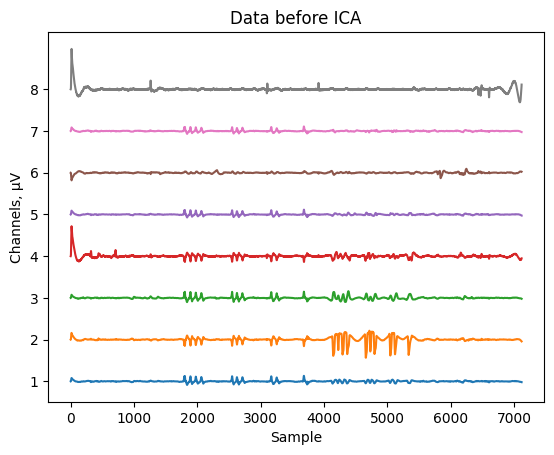

In [7]:
"""
This script visualizes multi-channel data by plotting each channel with vertical offsets to separate them,
setting y-axis ticks and labels for clarity, and adding labels and a title,
facilitating a clear view of the data before Independent Component Analysis (ICA).
"""

n_channels = data_bp_filtered.shape[1]  # number of channels
plt.plot(data_bp_filtered + range(1000, 1000*n_channels+1000, 1000))
plt.yticks(range(1000, 1000*n_channels+1000, 1000), range(1, n_channels+1))
plt.ylabel('Channels, µV')
plt.xlabel('Sample')
plt.title("Data before ICA")
plt.show()

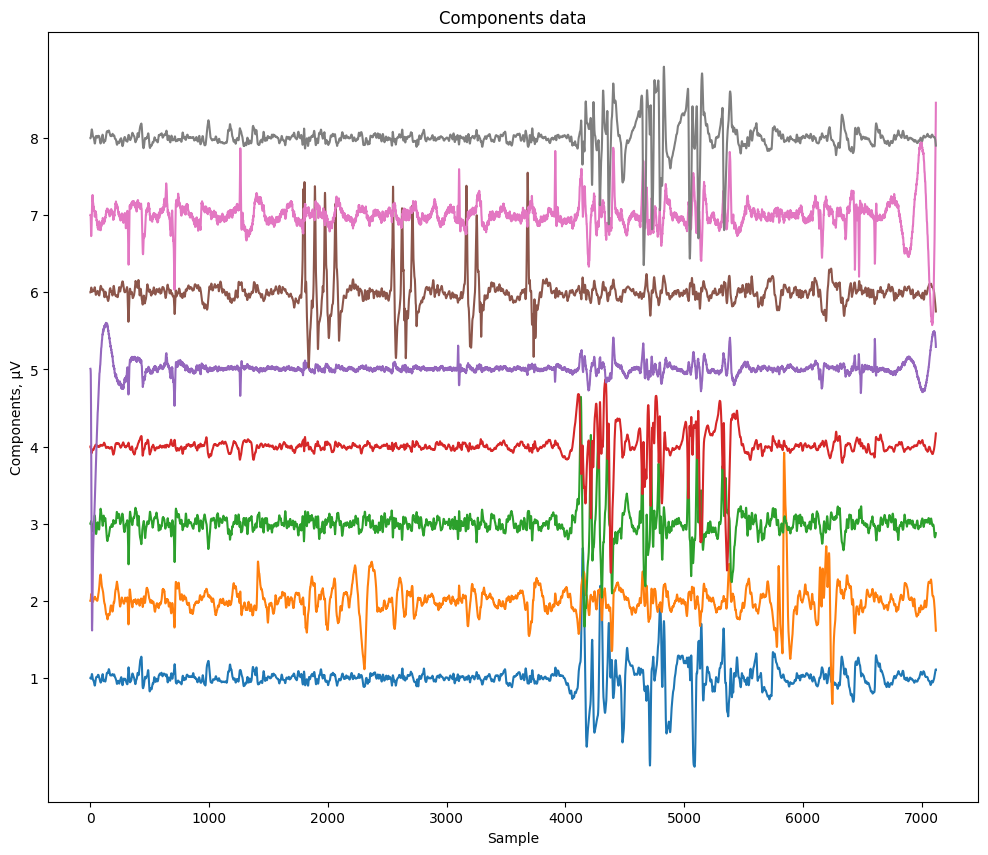

In [8]:
"""
The code first creates an instance of the FastICA class from the scikit-learn library,
specifying the number of components to be extracted as 8. The fit method is then called on the data_bp_filtered data, which performs the ICA decomposition and learns the unmixing matrix.
The transform method applies the learned unmixing matrix to the original data, resulting in the independent components stored in the components variable.
Next, the code plots the independent components using plt.plot,
with each component vertically offset by adding a constant value from the range(1, 1*n_channels+1, 1) sequence. This separation makes it easier to visualize the individual components.
"""

#pca=PCA(n_components=8)
ica=FastICA(n_components=8)

data_after_band_pass_filter_reshape = data_bp_filtered #np.transpose(data_bp_filtered)
#data_after_band_pass_filter_reshape = data_bp_filtered #np.transpose(data_bp_filtered)

#out_pca=pca.fit_transform(data_after_band_pass_filter_reshape)
out_ica=ica.fit_transform(data_after_band_pass_filter_reshape)

#fig, ax = plt.subplots(3,1,figsize=(10,8))
ica = FastICA(n_components=8)
ica.fit(data_after_band_pass_filter_reshape)
components = ica.transform(data_after_band_pass_filter_reshape)


offset = 5  # Adjust this value to increase or decrease the spacing
plt.figure(figsize=(12, 10))  # Increase figure size for better visibility
for i in range(8):
    plt.plot(components[:, i] + offset * i)

plt.yticks(range(0, offset * 8, offset), range(1, 9))
plt.ylabel('Components, µV')
plt.xlabel('Sample')
plt.title('Components data')
plt.show()

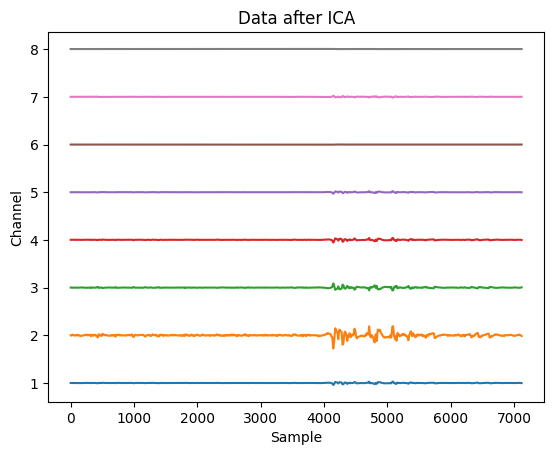

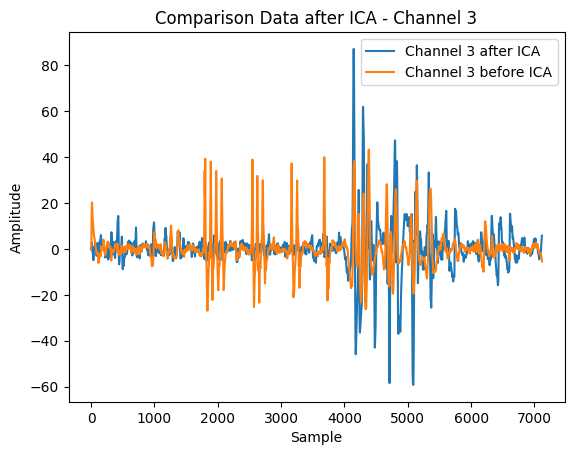

In [9]:
"""
After performing Independent Component Analysis (ICA) and visualizing the independent components, this script proceeds to remove all components except for the eye blink component (component 2) from the components matrix.
This is achieved by setting all other component values to zero using indexing operations.
The inverse_transform method of the ICA object is then called with the modified components matrix.
This method reconstructs the original data by applying the inverse of the unmixing matrix learned during the ICA decomposition.
The resulting data, stored in the restored variable, represents the original EEG data with the eye blink component removed.
Next, the code plots the restored data using plt.plot, with each channel vertically offset by adding a constant value from the range(1000, 1000*n_channels+1000, 1000) sequence.
This separation makes it easier to visualize the individual channels.
"""
# remove all components except for the eye blink component (component 2)
#components[:, 0] = 0
components[:, 1] = 0
components[:, 2] = 0
components[:, 3] = 0
components[:, 4] = 0
components[:, 5] = 0
components[:, 6] = 0
components[:, 7] = 0
# reconstruct EEG without blinks
restored = ica.inverse_transform(components)

plt.plot(restored + range(1000, 1000*n_channels+1000, 1000))
plt.yticks(range(1000, 1000*n_channels+1000, 1000), range(1, n_channels+1))
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.title("Data after ICA")
plt.show()

channel_data = restored[:, channel]
plt.plot(channel_data, label=f'Channel {channel + 1} after ICA')
plt.plot(channel_data_bp_filtered, label=f'Channel {channel + 1} before ICA')
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.title("Comparison Data after ICA - Channel " + str(channel+1))
plt.legend()
plt.show()

## Wavelet decomposition

Wavelet analysis for EEG involves the application of wavelet transforms to EEG signals to extract valuable information from the time-frequency domain. The main advantage of using wavelet analysis for EEG lies in its ability to provide time-frequency representations, which is essential for studying the dynamic changes in brain activity over time.

**Positive**

*   Time-Frequency Localization: Wavelet transforms provide time-frequency localization. This means that they can reveal how the frequency content of a signal changes over time. Different wavelet scales allow you to zoom in on different frequency ranges while maintaining good time resolution. This is crucial for capturing rapid changes in EEG signal frequencies that correspond to various brain activities.

* Adaptability to Signal Changes: EEG signals are highly variable due to factors like different brain states (e.g., awake, asleep, under stress) and external stimuli. The adaptive nature of wavelet analysis allows it to effectively capture the changes in frequency and amplitude as they occur, making it suitable for non-stationary signals like EEG.

* Multi-Resolution Analysis: Wavelets provide a multi-resolution analysis, which means they can represent a signal at different scales. This is particularly useful for capturing both fine details and coarse trends in EEG signals. High-frequency components can be analyzed at finer scales, while low-frequency components can be analyzed at coarser scales.

* Artifact Removal: EEG signals can be contaminated with various artifacts, such as muscle activity or electrical interference. Wavelet decomposition can help separate these artifacts from the neural activity by highlighting differences in their time-frequency characteristics.

* Feature Extraction: For various EEG applications, such as brain-computer interfaces or medical diagnosis, relevant features need to be extracted from the signal. Wavelet coefficients at different scales can serve as features that capture different aspects of the signal's time-frequency structure.

**Negative**

*   Complexity and Interpretability: Wavelet decomposition can produce complex time-frequency representations, which might make interpretation challenging, especially for those who are not familiar with wavelet analysis. The interpretation of the wavelet coefficients and their relationship to specific neural processes might not be straightforward.

* Selection of Wavelet Basis: The choice of wavelet basis function can greatly impact the results of the decomposition. Different wavelets are suited for different types of signal characteristics. Selecting an appropriate wavelet basis requires domain knowledge and experimentation, and a poor choice can lead to misleading interpretations.

* Artifact Sensitivity: While wavelet analysis can help separate brain-related signals from artifacts, it's still sensitive to various types of artifacts, and it might not always provide a perfect separation. The effectiveness of artifact removal depends on the similarity between the artifact and the neural signal in terms of their time-frequency properties.

* Trade-off between Time and Frequency Resolution: Although wavelets provide a good compromise between time and frequency resolution, there's still a trade-off. Some EEG applications might require very high time or frequency resolution, which might not be optimally met by wavelet decomposition.

* Wavelet Parameters: The decomposition process involves selecting parameters like the number of decomposition levels and the scale of the wavelet. These parameters can affect the results and might need to be adjusted for different EEG datasets, making the analysis process somewhat subjective.

* Limited Capture of Complex Neural Processes: Some complex neural processes involve interactions across multiple frequency bands, and wavelet decomposition might struggle to fully capture these intricate relationships. More advanced techniques like higher-order spectral analysis or time-frequency coherence might be more suitable for such cases.

* Computationally Intensive: Wavelet decomposition can be computationally intensive, especially if high-resolution analyses are required. This can be a limitation when processing large amounts of EEG data.

**How it works**  

Wavelet decomposition for EEG analysis involves breaking down EEG signals into different frequency components while retaining information about their occurrence in time. This is achieved by convolving the EEG signal with a family of wavelet functions of varying scales. Each wavelet scale captures different frequency information, and the resulting coefficients highlight when and where these frequencies are present in the signal. This enables simultaneous exploration of time-varying frequency patterns in EEG, providing insights into dynamic brain activity over different scales of time and frequency.


C:\Users\LAPTOP_MA\AppData\Local\Temp\ipykernel_15008\3300598936.py:26: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = signal.cwt(scaler_wave, signal.ricker, time)


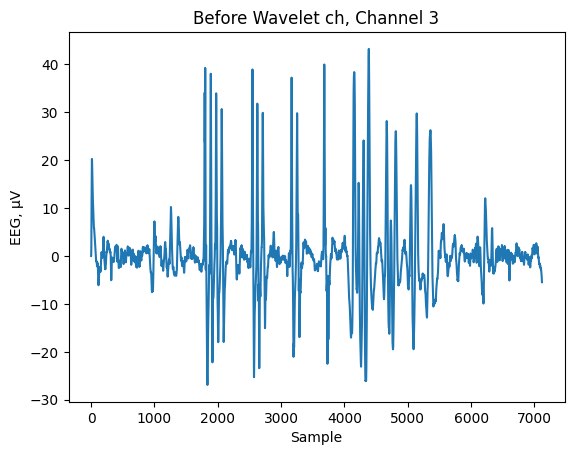

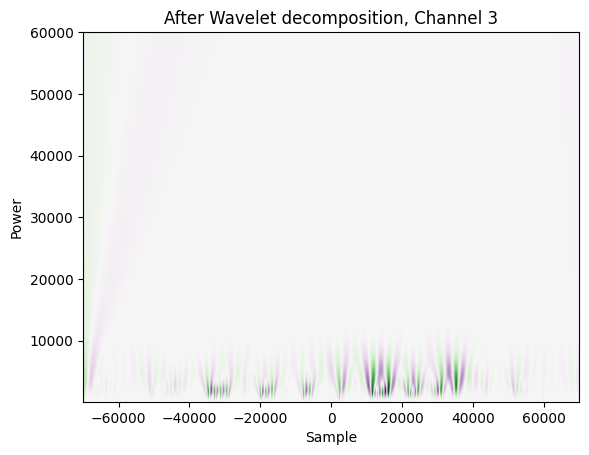

In [10]:
"""
This script conducts a wavelet decomposition analysis on EEG (electroencephalogram) data.
Initially, it constructs a time array and scales the EEG data.
Then, it applies a continuous wavelet transform (CWT) using a Ricker wavelet to the scaled data.
This transformed data is visualized both before and after the wavelet decomposition process.
The first plot displays the raw EEG data, while the second plot illustrates the resulting wavelet decomposition, showcasing the power distribution across time and frequency bands.
"""

time = []
scaler_wave = []
count = 0

for _ in channel_data_bp_filtered:
    count = count+0.1
    time.append(count)

data_for_wave = np.array(channel_data_bp_filtered)

sc_X = StandardScaler()
data_for_wave = data_for_wave.reshape(-1,1)
scaler = sc_X.fit_transform(data_for_wave)  # apply standard scaler

for a in scaler:
    scaler_wave.append(a[0])

cwtmatr = signal.cwt(scaler_wave, signal.ricker, time)
cwtmatr_yflip = np.flipud(cwtmatr)

plt.plot(channel_data_bp_filtered)
plt.ylabel('EEG, µV')
plt.title("Before Wavelet ch, Channel " + str(channel + 1) )
plt.xlabel('Sample')
plt.show()

plt.imshow(
    cwtmatr_yflip,
    extent=[-70000, 70000, 100, 60000],
    cmap='PRGn', aspect='auto',
    vmax=abs(cwtmatr).max(),
    vmin=-abs(cwtmatr).max()
)
plt.ylabel('Power')
plt.title("After Wavelet decomposition, Channel " + str(channel + 1))
plt.xlabel('Sample')
plt.show()

## Empirical Mode Decomposition (EMD)


EMD (Empirical Mode Decomposition) is a data analysis method used to explore the intrinsic oscillatory components present in EEG signals. EMD decomposes a complex EEG time series into simpler components called Intrinsic Mode Functions (IMFs) based on the data itself, without requiring any predefined basis functions.

**Positive**


*   Adaptive Decomposition: EMD adaptively decomposes a signal into a set of intrinsic mode functions (IMFs) based on the local characteristics of the signal. This is beneficial for handling muscle artifacts, as they can vary in amplitude and frequency over time.

* Localized Frequency Decomposition: Muscle artifacts often manifest as high-frequency oscillations in EEG signals. EMD's ability to decompose signals into IMFs with distinct frequency ranges can help separate the muscle-related components from the neural activity of interest.

* Separation of Components: EMD can effectively separate the different components present in the EEG signal, including muscle artifacts, neural activity, and other noise sources. This separation can aid in the selective removal of unwanted components.

* Preservation of Temporal Features: EMD retains the temporal features of the original signal within each IMF, allowing it to capture both rapid and gradual changes caused by muscle artifacts.

* Non-Parametric Approach: EMD doesn't rely on predefined models or assumptions about the signal's structure, making it well-suited for handling the complex and non-stationary nature of muscle artifacts.

**Negative**


*   Mode Mixing: EMD can suffer from mode mixing, where the intrinsic mode functions (IMFs) obtained may not cleanly separate the muscle artifacts from the neural signals. This can lead to incomplete or inaccurate artifact removal.

* Complexity of EEG Signals: EEG signals are complex and can include a variety of neural activities across different frequency ranges. EMD might not always effectively distinguish between muscle artifacts and neural components, especially when they overlap in frequency.

* Baseline Wander: EMD might not handle baseline wander effectively, which is a common low-frequency artifact in EEG signals. This can impact the accuracy of artifact removal.

* Subjectivity in Decomposition: EMD requires the selection of stopping criteria for the decomposition process, and these choices can be somewhat subjective. This subjectivity can lead to variations in results between different researchers or datasets.

* Artifact Variability: Muscle artifacts can vary widely in terms of amplitude, frequency, and time duration. EMD's adaptability might not guarantee consistent artifact removal across different EEG recordings or individuals.

* Computational Complexity: EMD can be computationally intensive, especially for longer EEG recordings. This can limit its practicality for real-time or large-scale applications.

**How it works**  
EMD decomposes a signal into components called Intrinsic Mode Functions (IMFs) by identifying local maxima and minima, creating upper and lower envelopes via interpolation, and finding their average.



[ 4  9 12 14 16 19 21 24 29 32 35 38 42 45 48 50 56 58 60 64 67 70 74 77
 80 82 85 90 93 97]


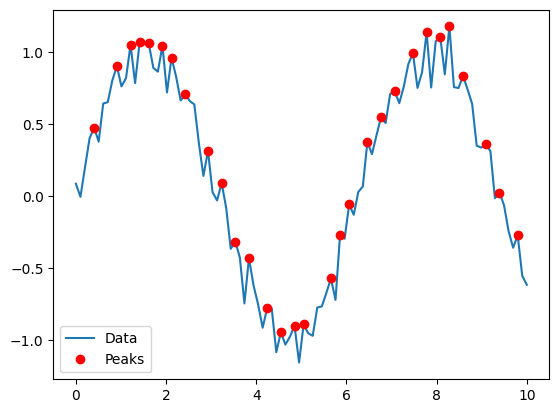

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Create some data (for example, a sine wave with noise)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=x.shape)

# Use scipy's find_peaks function
peaks, _ = find_peaks(y)
print (peaks)
# Plotting the data
plt.plot(x, y, label='Data')
plt.plot(x[peaks], y[peaks], 'ro', label='Peaks')
plt.legend()
plt.show()

Initialization complete
Iteration 0, inertia 5009.752832579043
Converged at iteration 0: center shift 0.7062103621358975 within tolerance 1000.0010000000002.
Initialization complete
Iteration 0, inertia 3314.9221282311837
Converged at iteration 0: center shift 0.20273118375326135 within tolerance 1000.0010000000002.
Initialization complete
Iteration 0, inertia 3696.5237452906367
Converged at iteration 0: center shift 0.1545330122124104 within tolerance 1000.0010000000002.
Initialization complete
Iteration 0, inertia 5557.787724832301
Converged at iteration 0: center shift 1.627772344159012 within tolerance 1000.0010000000002.
Initialization complete
Iteration 0, inertia 3336.4153974614574
Converged at iteration 0: center shift 0.2702251512200839 within tolerance 1000.0010000000002.
Initialization complete
Iteration 0, inertia 5316.9611530225875
Converged at iteration 0: center shift 0.12030818424236843 within tolerance 1000.0010000000002.
Initialization complete
Iteration 0, inertia 67

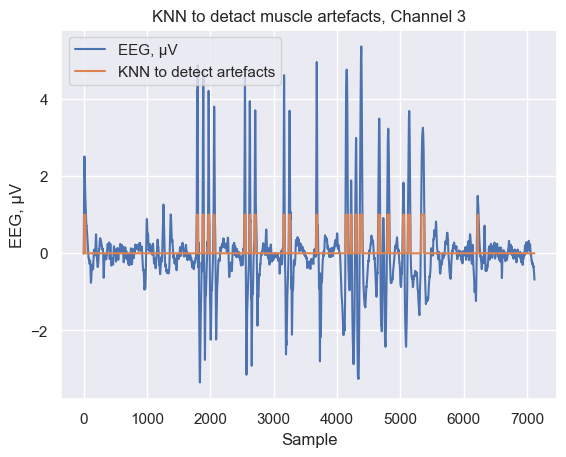

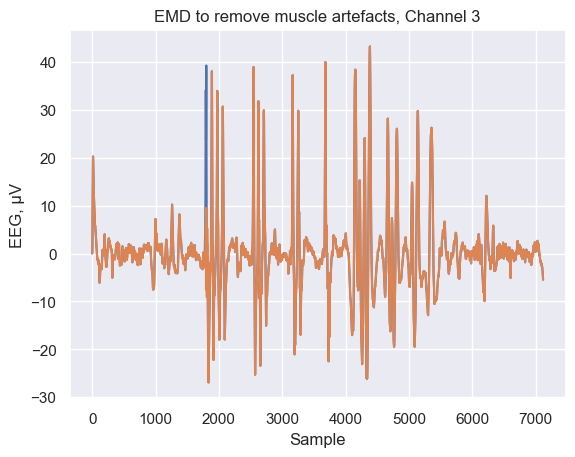

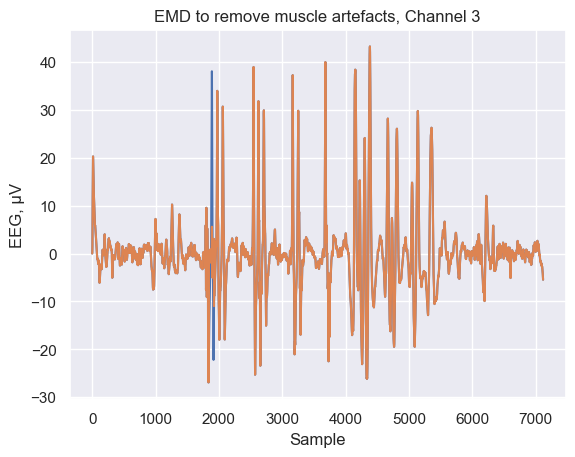

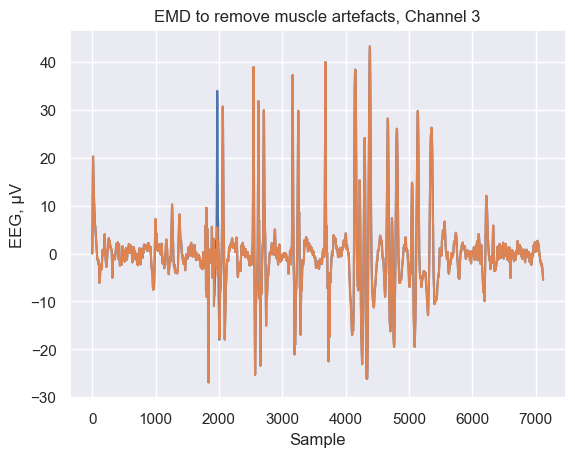

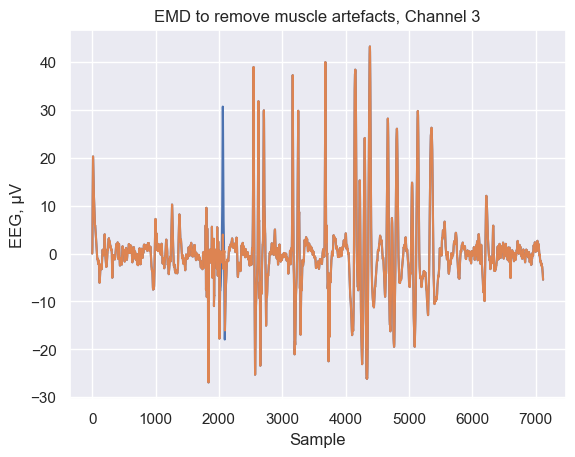

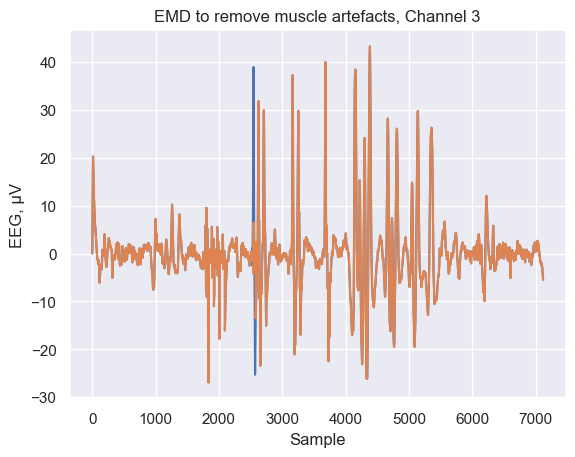

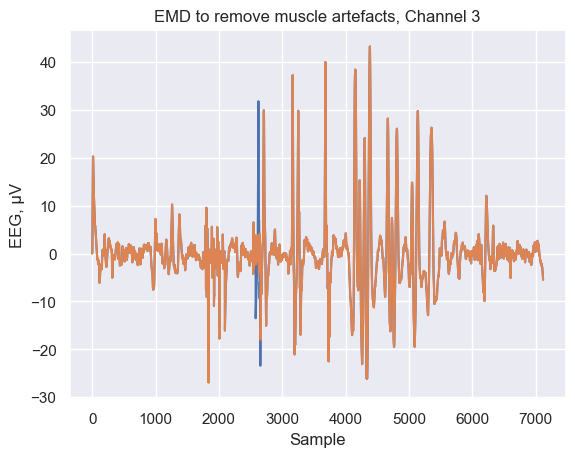

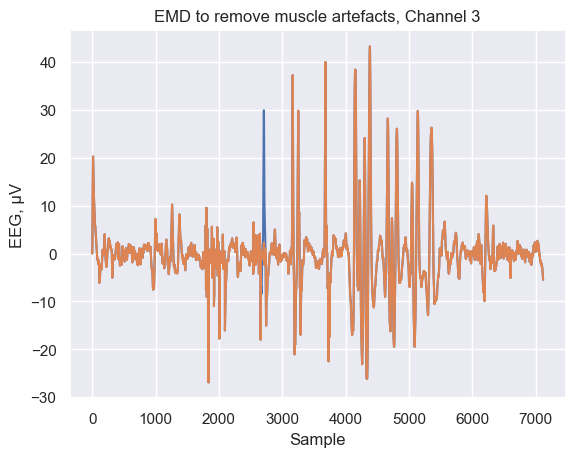

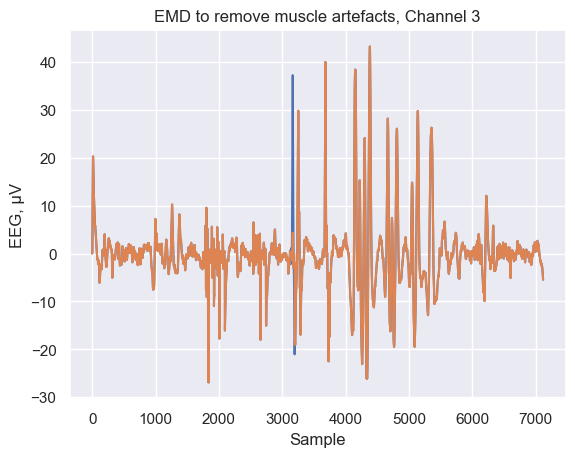

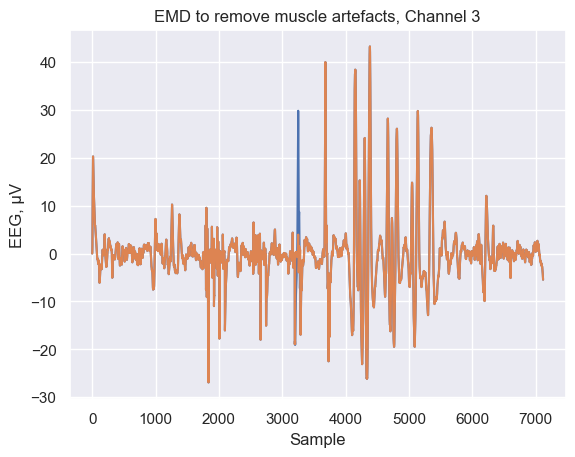

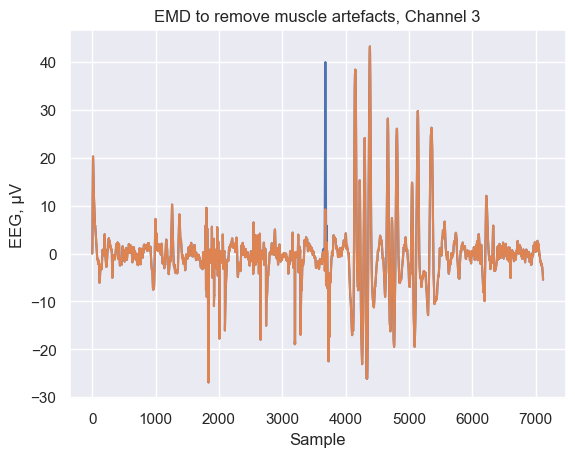

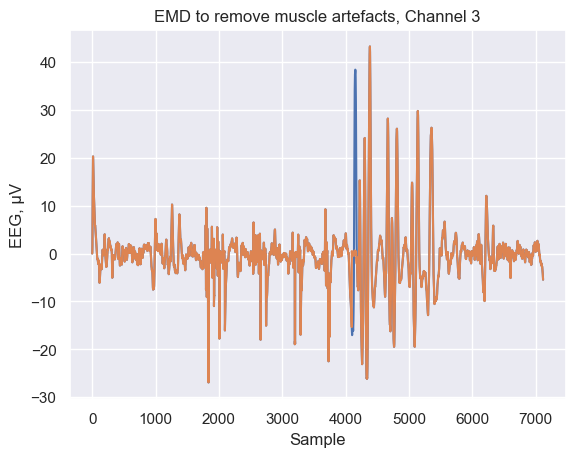

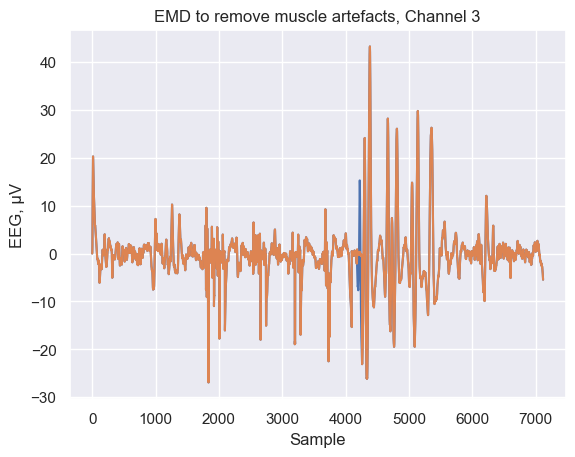

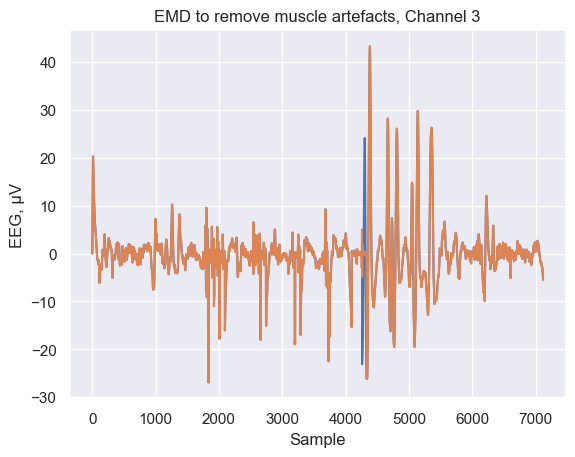

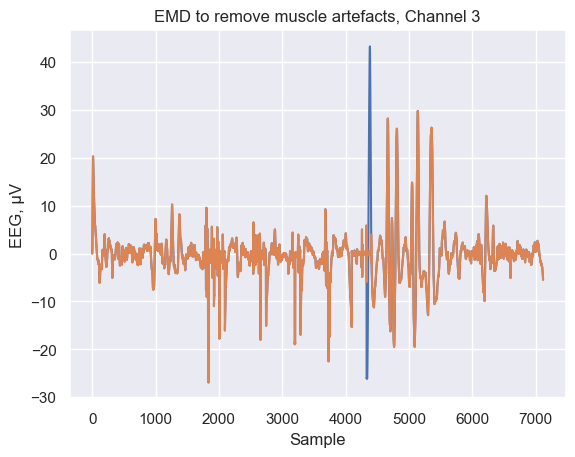

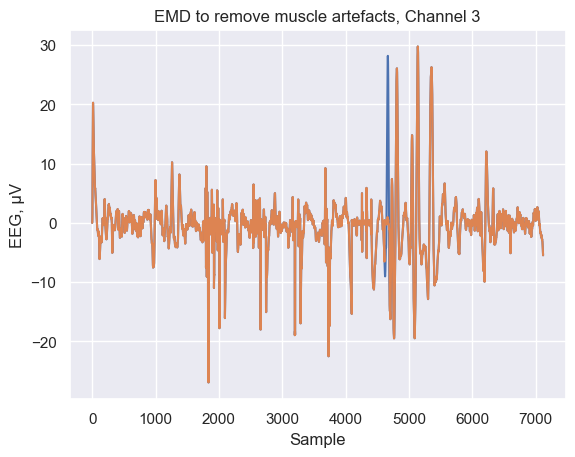

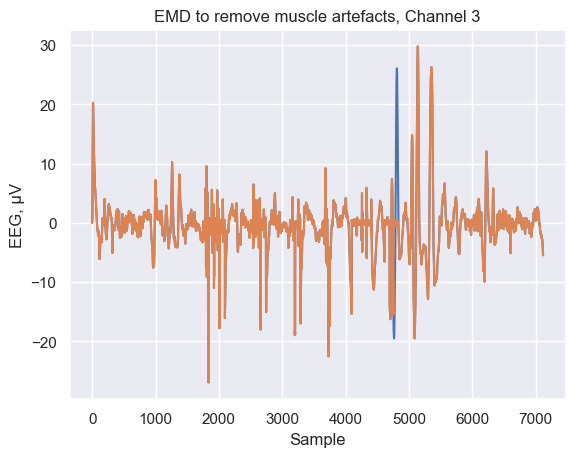

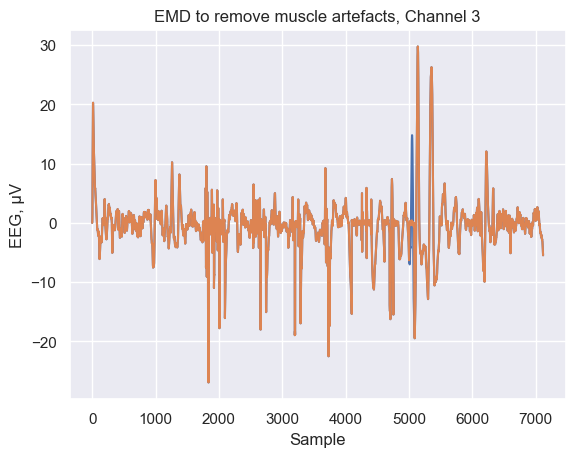

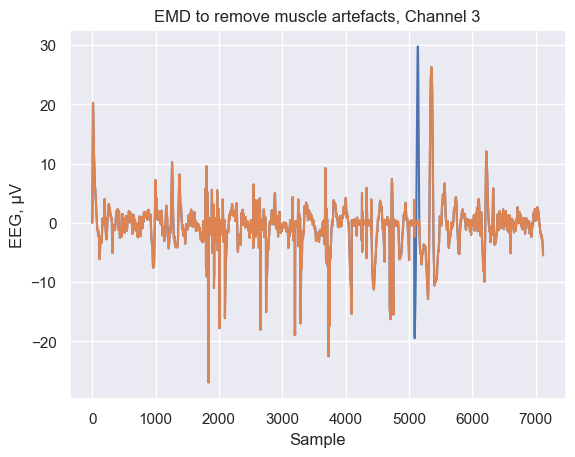

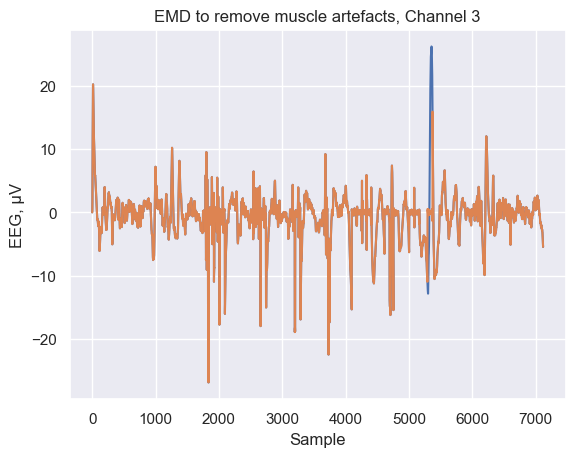

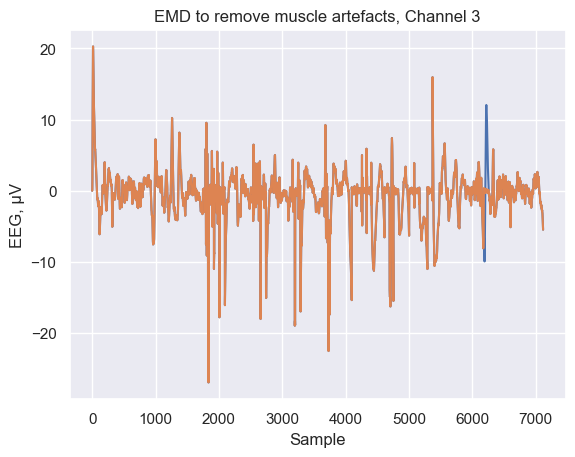

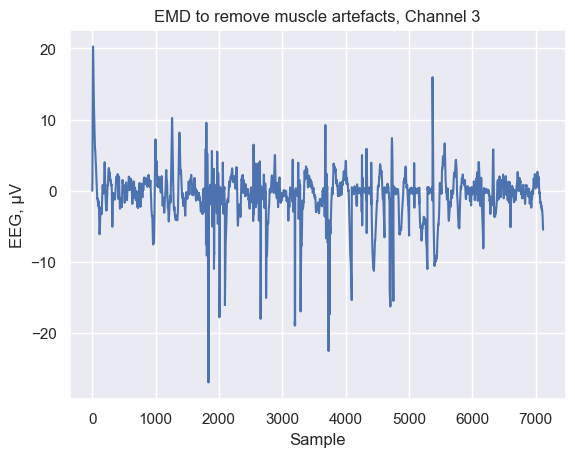

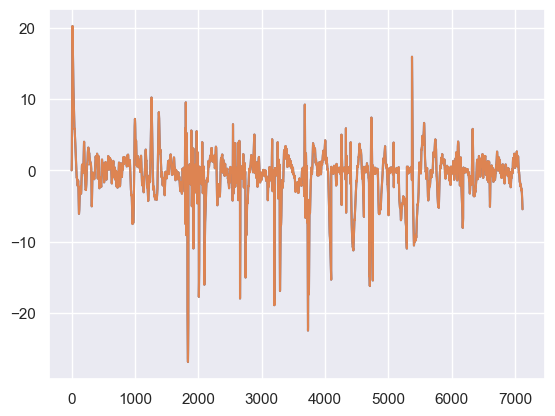

In [12]:
"""
This Python script aims to detect and remove muscle artifacts from physiological data.
It starts by scaling the data and then applies the K-means clustering algorithm to identify artifacts.
Once an artifact is detected, it performs Empirical Mode Decomposition (EMD) to extract the artifact and replaces it with the EMD result.
Finally, it plots the original data alongside the cleaned data without artifacts.
"""

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

EMD_data = channel_data_bp_filtered

for _ in EMD_data:
    count = count+0.1
    time.append(count)

just_for_graph = data_for_wave = EMD_data


sc_X = StandardScaler()
data_for_wave = data_for_wave.reshape(-1,1)
scaler = sc_X.fit_transform(data_for_wave)

scaler_wave = []
for a in scaler:
    scaler_wave.append(a[0])

kmeans = KMeans(
    n_clusters=2, init='k-means++', max_iter=3, tol=1000.001,
    verbose=10, random_state=1, n_init=10,  copy_x=True,
    algorithm='elkan') #algorithm= 'auto', 'full' or 'elkan
X = scaler
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

k_means_count = 0
shift_for_filter = 20
for_do_it_one_time = 0

plt.plot(scaler)
plt.plot(y_kmeans)
plt.legend(["EEG, µV","KNN to detect artefacts"])
plt.ylabel('EEG, µV')
plt.title("KNN to detact muscle artefacts, Channel " +str(channel + 1))
plt.xlabel('Sample')
plt.show()


for a in y_kmeans:
    k_means_count = k_means_count + 1
    if k_means_count>(shift_for_filter+shift_for_filter) and k_means_count<len(EMD_data)-shift_for_filter:
        if a == 1:
            if for_do_it_one_time == 0:
                plt.cla()
                for_do_it_one_time = 1
                data_for_EMD = EMD_data[(k_means_count-shift_for_filter - shift_for_filter):(k_means_count+shift_for_filter + shift_for_filter)]

                data_for_EMD = list(data_for_EMD)
                t = np.arange(0, len(data_for_EMD), 1)

                modes = data_for_EMD
                x = modes + t

                # Define signal
                t = np.linspace(0, 1, len(data_for_EMD))
                S = data_for_EMD
                eemd = EEMD()
                emd = eemd.EMD
                emd.extrema_detection="parabol"
                eIMFs = eemd.eemd(S, t)
                nIMFs = eIMFs.shape[0]
                data_for_replace = eIMFs[1]
                plt.plot(EMD_data)

                just_for_graph[(k_means_count-shift_for_filter - shift_for_filter):(k_means_count+shift_for_filter + shift_for_filter)] = data_for_replace
                plt.plot(just_for_graph)
                plt.ylabel('EEG, µV')
                plt.title("EMD to remove muscle artefacts, Channel " +str(channel + 1))
                plt.xlabel('Sample')

                plt.pause(0.1)
                plt.draw()

        else:
            for_do_it_one_time = 0
plt.plot(just_for_graph)
plt.ylabel('EEG, µV')
plt.title("EMD to remove muscle artefacts, Channel " +str(channel + 1))
plt.xlabel('Sample')

plt.pause(0.1)
plt.draw()

plt.plot(channel_data_bp_filtered)
plt.plot(just_for_graph)
plt.show()

### Empirical Mode Decomposition (EMD) without library

In certain applications, particularly those involving real-time tasks, the execution time of a task holds paramount importance. Consequently, understanding the implementation of methods without relying on external libraries can prove to be invaluable. Such knowledge ultimately empowers you to optimize program execution time and achieve notable speed enhancements.Here we demonstrate how to Empirical Mode Decomposition (EMD) to remove muscle artefacts without library

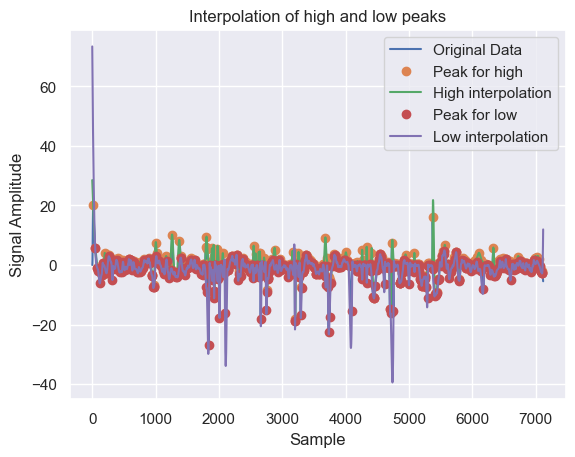

EMD_Y [50.96128331 49.30535342 47.68557055 ...  2.32227088  3.19413342
  4.15599359]


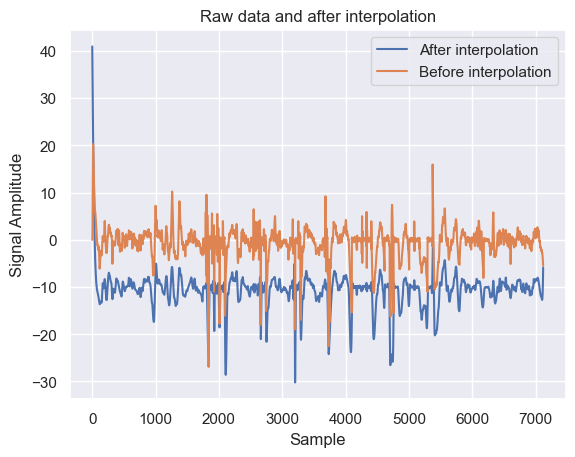

[50.96128331 49.30535342 47.68557055 ...  2.32227088  3.19413342
  4.15599359]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

global EMD_Y

# Assuming channel_data_bp_filtered is your signal data
# Replace with actual data for your use case
channel_data_bp_filtered = channel_data_bp_filtered #[:2000] #np.sin(np.linspace(0, 10, 100)) + np.random.normal(0, 0.1, 100)

def detect_peak():
    # Detect peaks and valleys using scipy's find_peaks
    high_peaks, _ = find_peaks(channel_data_bp_filtered)
    low_peaks, _ = find_peaks(-channel_data_bp_filtered)

    # Interpolation for high peaks
    f_high = interp1d(high_peaks, channel_data_bp_filtered[high_peaks], kind='cubic', fill_value="extrapolate")
    x_new = np.arange(0, len(channel_data_bp_filtered), 1)
    y_high_inter = f_high(x_new)

    # Interpolation for low peaks
    f_low = interp1d(low_peaks, channel_data_bp_filtered[low_peaks], kind='cubic', fill_value="extrapolate")
    y_low_inter = f_low(x_new)

    # Plotting high and low peaks with their interpolations
    plt.plot (channel_data_bp_filtered)
    plt.plot(high_peaks, channel_data_bp_filtered[high_peaks], 'o', x_new, y_high_inter, '-')
    plt.plot(low_peaks, channel_data_bp_filtered[low_peaks], 'o', x_new, y_low_inter, '-')
    plt.title("Interpolation of high and low peaks")
    plt.legend(["Original Data", "Peak for high", "High interpolation", "Peak for low", "Low interpolation"])
    plt.ylabel('Signal Amplitude')
    plt.xlabel('Sample')
    plt.show()

    # Average graph after interpolation (EMD-like)
    EMD_Y = (y_high_inter + y_low_inter) / 2 # !!!
    print ("EMD_Y", EMD_Y)
    plt.title("Raw data and after interpolation")
    plt.ylabel('Signal Amplitude')
    plt.xlabel('Sample')
    plt.plot(EMD_Y - 10)
    plt.plot(channel_data_bp_filtered)
    plt.legend(["After interpolation", "Before interpolation"])
    plt.show()
    return EMD_Y

# Call the function to detect peaks and plot the results
EMD_Y = detect_peak()

print(EMD_Y)